In [ ]:
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
import json
from matplotlib import pyplot as plt
from matplotlib import dates as md
from scipy.stats import pearsonr

### Once we're done: just the final result

In [ ]:
PROJPATH = Path().resolve().parent

PosixPath('/Users/christine/Projects/2023_Riverice')

In [ ]:
finalstations = PROJPATH / "data/stationdata_for_breakup/selectedstations.json"
with open(finalstations) as src:
    st = json.load(src)

sorted(list(set(sum(st.values(), []))))

['ANCHORAGE_MERRILL_FIELD',
 'BETHEL_AP',
 'BETTLES_AP',
 'BIG_DELTA_AP',
 'CHICKEN',
 'EAGLE',
 'FAIRBANKS_INTL_AP',
 'GULKANA_AP',
 'KENAI_AP',
 'KOTZEBUE_AP',
 'MCGRATH_AP',
 'MCKINLEY_PARK',
 'NENANA_MUN_AP',
 'NOME_AP',
 'NORTHWAY_AP',
 'NORTH_POLE',
 'SITKA_AP',
 'TALKEETNA_AP',
 'TANANA_AP']

### The process

In [ ]:
prefix = "DD25"       # set to TDD for Thawing Degree Days

config = {
    "TDD": {
        "deltaT": 32
    },
    "DD20": {
        "deltaT": 20
    },
    "DD25": {
        "deltaT": 25
    },
}

PROJPATH = Path().resolve().parent
breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / f"data/weatherstations/ACIS/{prefix}/dd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [ ]:
def datestr2dayssince(datestr: str, since: str = '0301') -> int:
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

In [ ]:
def dayssince2date(days: int, year: int, since: str = '0301') -> dt.date:
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

In [ ]:
type(dayssince2date(24, 2000))

datetime.date

### Load data

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

,id,siteID,year,breakup,JulianDay
0,7185,Chena River at Fairbanks,2023,2023-04-30,120
1,7186,Kuskokwim River at Nikolai,2023,2023-05-02,122
2,7188,Gakona River at Gakona,2023,2023-05-05,125
3,7189,Gulkana River nr Gakona,2023,2023-05-02,122
4,7190,Tanana River at Nenana,2023,2023-05-08,128
...,...,...,...,...,...
1529,5998,Yukon River at Ruby,1980,1980-05-07,128
1530,6165,Yukon River at Tanana,1980,1980-05-03,124
1531,6276,Yukon River at Dawson,1980,1980-05-06,127
1532,6521,Yukon River at Galena,1980,1980-05-10,131


In [ ]:
climatologies = pd.read_csv(PROJPATH / f"data/weatherstations/ACIS/{prefix}/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

,GULKANA_AIRPORT,TANANA_AIRPORT,KETCHIKAN_AIRPORT,COLLEGE_OBSERVATORY,AUKE_BAY,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,SKAGWAY_AIRPORT,EAGLE,BIG_DELTA_AIRPORT,...,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,YAKUTAT_AIRPORT,ALYESKA,NENANA_MUN_AP,HOMER_AIRPORT,NORTHWAY_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,DUTCH_HARBOR,MCKINLEY_PARK
d_since_march1,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,11.30,0.00,7.10,0.00,0.00,5.31,0.00,0.00,...,0.00,5.87,1.11,0.00,0.97,0.00,0.00,0.00,8.86,0.00
1,0.00,0.00,22.65,0.00,14.24,0.00,0.00,10.66,0.00,0.00,...,0.00,10.47,1.34,0.00,2.81,0.00,0.00,0.00,18.21,0.00
2,0.00,0.00,34.33,0.00,20.65,0.00,0.00,16.14,0.00,0.00,...,0.00,13.95,1.36,0.00,4.50,0.00,0.00,0.00,28.46,0.00
3,0.00,0.00,43.84,0.00,25.70,0.00,0.00,20.49,0.00,0.00,...,0.00,16.90,1.41,0.00,5.71,0.00,0.00,0.00,38.73,0.00
4,0.00,0.00,53.42,0.00,30.60,0.00,0.00,24.07,0.00,0.00,...,0.00,20.42,1.46,0.00,8.42,0.00,0.00,0.00,49.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1640.43,1695.06,2482.02,1863.22,2355.59,1429.77,2067.13,2334.36,1718.14,1848.59,...,1948.71,1911.16,1854.28,1859.73,1814.11,1666.94,1439.68,1973.00,1734.20,1426.77
118,1672.22,1729.92,2514.10,1899.05,2387.85,1459.15,2101.76,2367.84,1753.60,1882.80,...,1981.83,1939.38,1885.47,1894.85,1842.23,1700.21,1469.68,2010.40,1757.52,1457.11
119,1704.05,1765.71,2546.48,1934.92,2420.80,1488.58,2136.26,2400.26,1789.71,1917.92,...,2015.31,1968.21,1916.29,1930.30,1871.23,1734.44,1499.42,2048.65,1781.57,1486.70


In [ ]:
dd = sorted(list(stationdata.glob("*.csv")))

In [ ]:
def retrieve_dd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_dd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.days_since_march1-offset][str(row.year)] - climatologies[stationname].iloc[row.days_since_march1-offset]
    except KeyError:
        return np.nan
    
def retrieve_dd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    days_since_march1 = datestr2dayssince(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[days_since_march1][str(row.year)] - climatologies[stationname].iloc[days_since_march1]
    except KeyError:
        return np.nan

## Model breakup by DD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in dd:
    stationname = pth.stem[:-18]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,JulianDay,days_since_march1,ALYESKA,ANCHORAGE_MERRILL_FIELD,ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT,AUKE_BAY,...,NENANA_MUN_AP,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SAINT_PAUL_ISLAND_AIRPORT,SITKA_AIRPORT,SKAGWAY_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT,YAKUTAT_AIRPORT
0,7185,Chena River at Fairbanks,2023,2023-04-30,120,60,-66.62,-88.22,-104.19,-99.20,...,NaN,8.89,-99.10,-137.54,156.85,-25.44,-48.47,-90.76,NaN,-69.17
1,7186,Kuskokwim River at Nikolai,2023,2023-05-02,122,62,-66.72,-90.54,-107.04,-97.95,...,NaN,17.11,-99.73,-127.78,153.09,-25.36,-47.01,-95.29,NaN,-74.43
2,7188,Gakona River at Gakona,2023,2023-05-05,125,65,-77.56,-106.36,-123.17,-109.25,...,NaN,10.93,-114.76,-126.58,147.66,-30.88,-57.91,-107.84,NaN,-82.82
3,7189,Gulkana River nr Gakona,2023,2023-05-02,122,62,-66.72,-90.54,-107.04,-97.95,...,NaN,17.11,-99.73,-127.78,153.09,-25.36,-47.01,-95.29,NaN,-74.43
4,7190,Tanana River at Nenana,2023,2023-05-08,128,68,-85.09,-117.06,-129.99,-106.44,...,NaN,-0.84,-121.41,-129.32,145.72,-29.23,-55.16,-115.93,NaN,-90.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,5998,Yukon River at Ruby,1980,1980-05-07,128,67,NaN,NaN,149.23,48.64,...,NaN,185.83,144.34,132.30,262.96,90.40,NaN,118.49,65.52,231.95
1530,6165,Yukon River at Tanana,1980,1980-05-03,124,63,NaN,NaN,148.53,33.46,...,NaN,137.33,123.55,108.62,246.11,71.97,NaN,112.31,46.95,206.67
1531,6276,Yukon River at Dawson,1980,1980-05-06,127,66,NaN,NaN,149.36,43.09,...,NaN,175.80,138.07,126.48,258.44,87.12,NaN,116.94,64.14,225.93
1532,6521,Yukon River at Galena,1980,1980-05-10,131,70,NaN,NaN,150.81,58.86,...,NaN,218.19,149.83,128.57,271.47,99.22,NaN,107.69,69.50,231.92


In [ ]:
locations = breakup.siteID.unique()
locations

array(['Chena River at Fairbanks', 'Kuskokwim River at Nikolai',
       'Gakona River at Gakona', 'Gulkana River nr Gakona',
       'Tanana River at Nenana', 'Yukon River at Dawson',
       'Yentna River at Lake Creek', 'Susitna River at Sunshine',
       'Yukon River at Eagle', 'Kuskokwim River at Stony River',
       'Kuskokwim River at Sleetmute',
       'Tanana River nr Manley Hot Springs', 'Kuskokwim River at McGrath',
       'Kuskokwim River at Red Devil', 'Kuskokwim River at Crooked Creek',
       'Koyukuk River at Allakaket', 'Yukon River at Tanana',
       'Yukon River at Fort Yukon', 'Yukon River at Circle',
       'Koyukuk River at Bettles', 'Koyukuk River at Hughes',
       'Kuskokwim River at Aniak', 'Yukon River at Ruby',
       'Kuskokwim River at Kalskag', 'Kuskokwim River at Tuluksak',
       'Kuskokwim River at Akiak', 'Yukon River at Galena',
       'Kuskokwim River at Bethel', 'Yukon River at Kaltag',
       'Yukon River at Holy Cross', 'Yukon River at Anvik',
     

In [ ]:
selected_location = 'Buckland River at Buckland' # 'Yukon River at Russian Mission'
selected_short = 'Buckland'

In [ ]:
output = (
    breakup
    .groupby(['siteID'], as_index=False)
    .agg({'days_since_march1': ['mean', 'std']})
)
output.columns = ['siteID', 'days_since_march1_mean', 'days_since_march1_std']
output

,siteID,days_since_march1_mean,days_since_march1_std
0,Buckland River at Buckland,77.147059,8.206178
1,Chena River at Fairbanks,56.218750,7.412868
2,Chisana River at Northway,54.812500,5.991594
3,Gakona River at Gakona,61.342857,10.341074
4,Gulkana River nr Gakona,60.529412,9.280920
5,Kobuk River at Ambler,77.526316,6.828940
6,Kobuk River at Kobuk,75.450000,6.894628
7,Kobuk River at Shungnak,76.812500,7.045646
8,Koyukuk River at Allakaket,70.052632,6.542780
9,Koyukuk River at Bettles,69.523810,6.522898


In [ ]:
output['breakup_mean'] = dt.datetime(2000, 3, 1) + dt.timedelta(days=breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.mean())
# df_std = breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.std()
# df_mean_plus = df_mean + dt.timedelta(days=df_std)
# df_mean_minus = df_mean - dt.timedelta(days=df_std)

In [ ]:
output['mean_breakup_date'] = (dt.datetime(2000, 3, 1) + pd.to_timedelta(output.days_since_march1_mean, 'd')).dt.strftime("%m-%d")
output

,siteID,days_since_march1_mean,days_since_march1_std,breakup_mean,mean_breakup_date
0,Buckland River at Buckland,77.147059,8.206178,2000-05-17 03:31:45.882353,05-17
1,Chena River at Fairbanks,56.218750,7.412868,2000-05-17 03:31:45.882353,04-26
2,Chisana River at Northway,54.812500,5.991594,2000-05-17 03:31:45.882353,04-24
3,Gakona River at Gakona,61.342857,10.341074,2000-05-17 03:31:45.882353,05-01
4,Gulkana River nr Gakona,60.529412,9.280920,2000-05-17 03:31:45.882353,04-30
5,Kobuk River at Ambler,77.526316,6.828940,2000-05-17 03:31:45.882353,05-17
6,Kobuk River at Kobuk,75.450000,6.894628,2000-05-17 03:31:45.882353,05-15
7,Kobuk River at Shungnak,76.812500,7.045646,2000-05-17 03:31:45.882353,05-16
8,Koyukuk River at Allakaket,70.052632,6.542780,2000-05-17 03:31:45.882353,05-10
9,Koyukuk River at Bettles,69.523810,6.522898,2000-05-17 03:31:45.882353,05-09


In [ ]:
with open(outpath / "breakupdate_mean_std.csv", "w") as dst:
    dst.write("# Mean and std of breakupdate in days since March 1, 1983-3 \n")
    dst.write("# For all selected sites\n")
    dst.write("# \n")
    output.to_csv(dst)

In [ ]:
df_mean = dt.datetime(2000, 3, 1) + dt.timedelta(days=breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.mean())
df_std = breakup_anomaly[breakup_anomaly['siteID'] == selected_location].days_since_march1.std()
df_mean_plus = df_mean + dt.timedelta(days=df_std)
df_mean_minus = df_mean - dt.timedelta(days=df_std)

In [ ]:
df_mean

datetime.datetime(2000, 5, 17, 3, 31, 45, 882353)

In [ ]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix=f"{prefix}_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception(f"Sorry, the {stationnames} isn't in valid names: {breakupDF.columns}")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['days_since_march1'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,  
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )        
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='days_since_march1', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='days_since_march1', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel(f"{prefix} anomaly")
                ax.set_ylabel("Days since March 1")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if show_plots:
                    plt.show()
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
    return outputrecords

Selected only, all dates

In [ ]:
## Use this later

output = {}

for ii in range(10):
    datepoint = dt.datetime(2000, 4, 20) + dt.timedelta(days=ii)
    datestr = datepoint.strftime('%m-%d')
    breakup_anomaly_fixed = breakup.copy()

    for pth in dd:
        stationname = pth.stem[:-18]
        print(stationname)
        teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
        breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
            lambda row: retrieve_dd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)
    output[datestr] = returnrec

ALYESKA
ANCHORAGE_MERRILL_FIELD
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT
AUKE_BAY
BARROW_AIRPORT
BETHEL_AIRPORT
BETTLES_AIRPORT
BIG_DELTA_AIRPORT
CHICKEN
COLD_BAY_AIRPORT
COLLEGE_OBSERVATORY
CORDOVA_AIRPORT
DUTCH_HARBOR
EAGLE
FAIRBANKS_INTL_AP
GULKANA_AIRPORT
HAINES_AIRPORT
HOMER_AIRPORT
ILIAMNA_AIRPORT
JUNEAU_AIRPORT
KENAI_AIRPORT
KETCHIKAN_AIRPORT
KING_SALMON_AIRPORT
KODIAK_AIRPORT
KOTZEBUE_AIRPORT
MCGRATH_AP
MCKINLEY_PARK
NENANA_MUN_AP
NOME_AIRPORT
NORTHWAY_AIRPORT
NORTH_POLE
SAINT_PAUL_ISLAND_AIRPORT
SITKA_AIRPORT
SKAGWAY_AIRPORT
TALKEETNA_AIRPORT
TANANA_AIRPORT
YAKUTAT_AIRPORT
ALYESKA
ANCHORAGE_MERRILL_FIELD
ANCHORAGE_TED_STEVENS_INTERNATIONAL_AIRPORT
AUKE_BAY
BARROW_AIRPORT
BETHEL_AIRPORT
BETTLES_AIRPORT
BIG_DELTA_AIRPORT
CHICKEN
COLD_BAY_AIRPORT
COLLEGE_OBSERVATORY
CORDOVA_AIRPORT
DUTCH_HARBOR
EAGLE
FAIRBANKS_INTL_AP
GULKANA_AIRPORT
HAINES_AIRPORT
HOMER_AIRPORT
ILIAMNA_AIRPORT
JUNEAU_AIRPORT
KENAI_AIRPORT
KETCHIKAN_AIRPORT
KING_SALMON_AIRPORT
KODIAK_AIRPORT
KOTZEBUE_AIRPORT
M

In [ ]:
output = {}

for ii in range(75):
    datepoint = dt.datetime(2000, 4, 1) + dt.timedelta(days=ii)
    datestr = datepoint.strftime('%m-%d')
    breakup_anomaly_fixed = breakup.copy()

    for pth in dd:
        stationname = pth.stem[:-18]
        teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
        breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
            lambda row: retrieve_dd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed, locations=[selected_location])
    output[datestr] = returnrec
    


In [ ]:
output.keys()

dict_keys(['04-01', '04-02', '04-03', '04-04', '04-05', '04-06', '04-07', '04-08', '04-09', '04-10', '04-11', '04-12', '04-13', '04-14', '04-15', '04-16', '04-17', '04-18', '04-19', '04-20', '04-21', '04-22', '04-23', '04-24', '04-25', '04-26', '04-27', '04-28', '04-29', '04-30', '05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10', '05-11', '05-12', '05-13', '05-14', '05-15', '05-16', '05-17', '05-18', '05-19', '05-20', '05-21', '05-22', '05-23', '05-24', '05-25', '05-26', '05-27', '05-28', '05-29', '05-30', '05-31', '06-01', '06-02', '06-03', '06-04', '06-05', '06-06', '06-07', '06-08', '06-09', '06-10', '06-11', '06-12', '06-13', '06-14'])

In [ ]:
selected_correlationseriesDF = pd.DataFrame.from_records([
    {'date': item, 'stationname': subitem['stationname'], 
     'location': subitem['location'], 'r2': subitem['r2value']} 
    for item in output for subitem in output[item]])
selected_correlationseriesDF.fillna(0, inplace=True)
selected_correlationseriesDF['dummydate'] = '2000-'+ selected_correlationseriesDF['date']
selected_correlationseriesDF['DateStamp'] = pd.to_datetime(selected_correlationseriesDF['dummydate'], format='%Y-%m-%d')
selected_correlationseriesDF.drop(columns=['dummydate'], inplace=True)
selected_correlationseriesDF['stationname'] = selected_correlationseriesDF['stationname'].str.replace('AIRPORT', 'AP')
selected_correlationseriesDF['stationname'] = selected_correlationseriesDF['stationname'].str.replace('INTERNATIONAL', 'INTL')
selected_correlationseriesDF

,date,stationname,location,r2,DateStamp
0,04-01,days_since_march1,Buckland River at Buckland,1.000000,2000-04-01
1,04-01,ALYESKA,Buckland River at Buckland,0.000041,2000-04-01
2,04-01,ANCHORAGE_MERRILL_FIELD,Buckland River at Buckland,0.005090,2000-04-01
3,04-01,ANCHORAGE_TED_STEVENS_INTL_AP,Buckland River at Buckland,0.002772,2000-04-01
4,04-01,AUKE_BAY,Buckland River at Buckland,0.006928,2000-04-01
...,...,...,...,...,...
2845,06-14,SITKA_AP,Buckland River at Buckland,0.238567,2000-06-14
2846,06-14,SKAGWAY_AP,Buckland River at Buckland,0.176058,2000-06-14
2847,06-14,TALKEETNA_AP,Buckland River at Buckland,0.315712,2000-06-14
2848,06-14,TANANA_AP,Buckland River at Buckland,0.257549,2000-06-14


In [ ]:
grouped = selected_correlationseriesDF.drop(
        columns=['date', 'location']).groupby(
                ['stationname', pd.Grouper(key='DateStamp', freq='15D')]).mean().reset_index()

In [ ]:
(
    grouped
        .groupby(['DateStamp'])
        .apply(lambda group: group.nlargest(5, columns='r2'))
).index

MultiIndex([('2000-04-01', 185),
            ('2000-04-01', 135),
            ('2000-04-01',  40),
            ('2000-04-01', 145),
            ('2000-04-01',  70),
            ('2000-04-16', 186),
            ('2000-04-16', 121),
            ('2000-04-16', 141),
            ('2000-04-16', 136),
            ('2000-04-16', 131),
            ('2000-05-01', 187),
            ('2000-05-01', 122),
            ('2000-05-01', 142),
            ('2000-05-01', 137),
            ('2000-05-01', 132),
            ('2000-05-16', 188),
            ('2000-05-16', 123),
            ('2000-05-16', 143),
            ('2000-05-16', 138),
            ('2000-05-16', 133),
            ('2000-05-31', 189),
            ('2000-05-31', 124),
            ('2000-05-31', 144),
            ('2000-05-31', 139),
            ('2000-05-31',  29)],
           names=['DateStamp', None])

In [ ]:
sb.set_style('darkgrid')
sb.set_context('talk', font_scale=1)

In [ ]:
fig = plt.figure()
selected_correlationseriesDF.drop(
    columns=['date', 'dummydate']).pivot(
        index='DateStamp', columns='stationname', 
        values='r2').plot(
            subplots=True, layout=(8,5), figsize=(15, 17),
            sharey=True, ylabel='', title=list(selected_correlationseriesDF.stationname.unique()), legend=False)
plt.set_xlabels('')
fig.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)


KeyError: "['dummydate'] not found in axis"

<Figure size 640x480 with 0 Axes>

In [ ]:
sb.set_context('poster', font_scale=1)

In [ ]:
['ANCHORAGE_TED_STEVENS_INTL_AP', 'BETHEL_AP', 'BETTLES_AP', 'BIG_DELTA_AP', 'CHICKEN',
       'EAGLE', 'FAIRBANKS_INTL_AP', 'GULKANA_AP', 'HAINES_AP',
       'HOMER_AP', 'KENAI_AP', 
       'KING_SALMON_AP', 'KODIAK_AP', 'KOTZEBUE_AP', 'MCGRATH_AP',
       'MCKINLEY_PARK', 'NENANA_MUN_AP', 'NOME_AP', 'NORTHWAY_AP',
       'NORTH_POLE', 'SAINT_PAUL_ISLAND_AP', 'SITKA_AP', 
       'TALKEETNA_AP', 'TANANA_AP', ]

In [ ]:
selected_correlationseriesDF = selected_correlationseriesDF.where(selected_correlationseriesDF.stationname.isin(['ANCHORAGE_TED_STEVENS_INTL_AP', 'BETHEL_AP', 'BETTLES_AP', 'BIG_DELTA_AP', 'CHICKEN',
       'EAGLE', 'FAIRBANKS_INTL_AP', 'GULKANA_AP', 'HAINES_AP',
       'HOMER_AP', 'KENAI_AP', 
       'KING_SALMON_AP', 'KODIAK_AP', 'KOTZEBUE_AP', 'MCGRATH_AP',
       'MCKINLEY_PARK', 'NENANA_MUN_AP', 'NOME_AP', 'NORTHWAY_AP',
       'NORTH_POLE', 'SAINT_PAUL_ISLAND_AP', 'SITKA_AP', 
       'TALKEETNA_AP', 'TANANA_AP', ]))

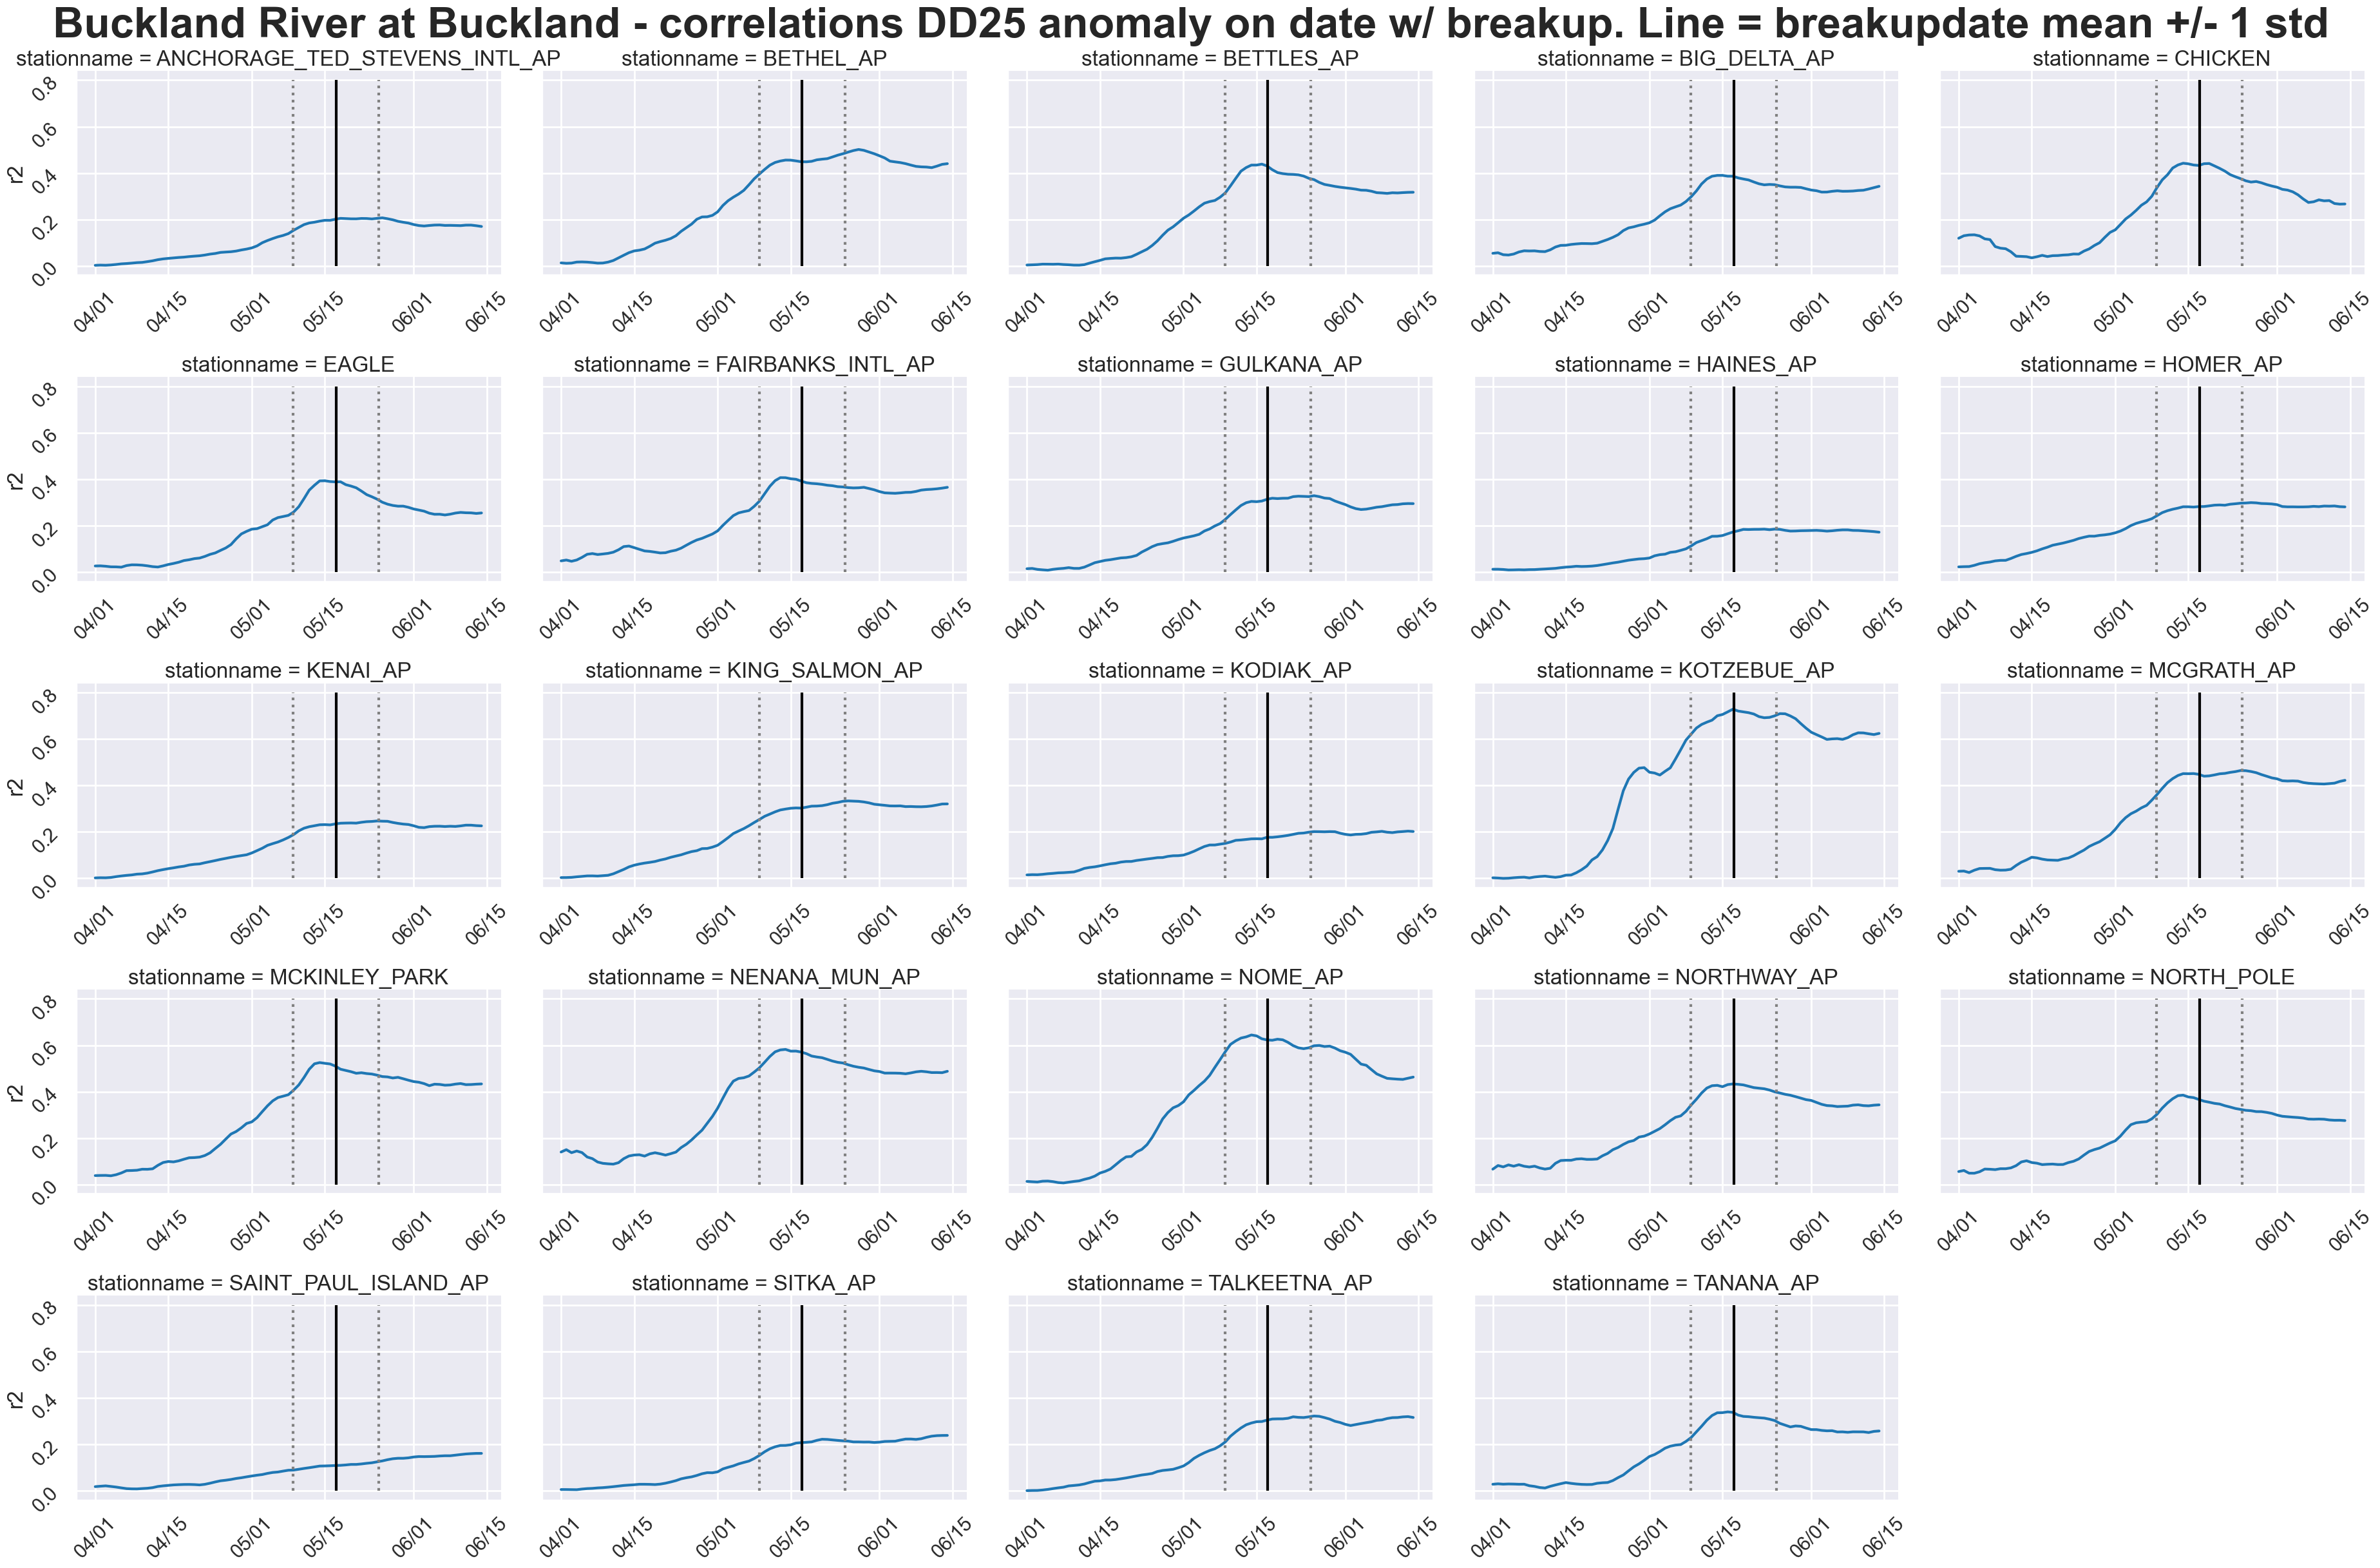

In [ ]:

g = sb.relplot(selected_correlationseriesDF, x='DateStamp', y='r2', col='stationname', col_wrap=5, kind='line', aspect=1.5, facet_kws={'sharex': 'col'} )
xformatter = md.DateFormatter("%m/%d")
g.set_xlabels('')

# g.set_xticklabels(rotation=90)
for ax in g.axes:
    ax.tick_params(rotation=45, labelbottom=True)
    ax.xaxis.set_major_formatter(xformatter)
    ax.vlines(x=df_mean, ymin=0, ymax=0.8, colors='black')
    ax.vlines(x=df_mean_plus, ymin=0, ymax=0.8, colors='grey', linestyles='dotted')
    ax.vlines(x=df_mean_minus, ymin=0, ymax=0.8, colors='grey', linestyles='dotted')

g.fig.tight_layout()
g.fig.suptitle(f"{selected_location} - correlations {prefix} anomaly on date w/ breakup. Line = breakupdate mean +/- 1 std", fontsize=48, fontweight='bold')
g.fig.subplots_adjust(top=0.94,)



### Write top correlations to files